Purpose: to answer when vaccination process will be ended. It uses algorightm to determine herd immunity and 
    consider that threashold when vaccination is most effective. 
    
    By knowing this vaccine can be effectively distributed to whole community and so reduces the requirement of essential 
    vaccination.
    
    This mode also uses timeseries to predict the daily covid cases count and track vaccinated subjects. 
    
    It plot a graph to show predicted cases and immunity as time series to know when pendemic could be 
    officially ended.
    
    
    It uses two data sources, census data and confirmed cases data from C3.AI Covid data lake.
    
    
    

In [ ]:
import pandas as pd
from matplotlib import pyplot as plt
import datetime

In [ ]:
print("pandas version", pd.__version__)
assert pd.__version__[0] >= "1", "To use this notebook, upgrade to the newest version of pandas. See https://pandas.pydata.org/pandas-docs/stable/getting_started/install.html for details."


In [ ]:
import c3aidatalake

In [ ]:
today = pd.Timestamp.now() - datetime.timedelta(days = 7)
today = today.strftime("%Y-%m-%d")

locations = [
       "California_UnitedStates"
]

metrics = [
    "JHU_ConfirmedCases"
]

complete_timeseries = c3aidatalake.evalmetrics(
    "outbreaklocation",
    {
        "spec" : {
            "ids" : locations,
            "expressions" : metrics,
            "start" : "2020-02-15",
            "end" : today,
            "interval" : "DAY",
        }
    },
    get_all = True
)

complete_timeseries['index'] = range(1, len(complete_timeseries) + 1)

complete_timeseries = complete_timeseries.rename(columns={'California_UnitedStates.JHU_ConfirmedCases.data':'ConfirmedCases'})

complete_timeseries.tail()


In [119]:
population_limits = (
    f"contains(parent, 'California_UnitedStates') &&" # US data
    "( populationAge == 'Total' ) && " # Limit age groups
    "gender == 'Male/Female' && year == 2018 && origin == 'United States Census'" # From 2018 estimates
)

census = c3aidatalake.fetch(
    "populationdata",
    {
      "spec": {
        "filter": population_limits
      }
    },
    get_all = True
)

census['state'] = census['parent.id']
census = census.rename(columns={'parent.id': 'location'})

census

year       gender      race              ethnicity populationAge  \
0   2018  Male/Female  Any race  Hispanic/Not Hispanic         Total   
1   2018  Male/Female  Any race  Hispanic/Not Hispanic         Total   
2   2018  Male/Female  Any race  Hispanic/Not Hispanic         Total   
3   2018  Male/Female  Any race  Hispanic/Not Hispanic         Total   
4   2018  Male/Female  Any race  Hispanic/Not Hispanic         Total   
5   2018  Male/Female  Any race  Hispanic/Not Hispanic         Total   
6   2018  Male/Female  Any race  Hispanic/Not Hispanic         Total   
7   2018  Male/Female  Any race  Hispanic/Not Hispanic         Total   
8   2018  Male/Female  Any race  Hispanic/Not Hispanic         Total   
9   2018  Male/Female  Any race  Hispanic/Not Hispanic         Total   
10  2018  Male/Female  Any race  Hispanic/Not Hispanic         Total   
11  2018  Male/Female  Any race  Hispanic/Not Hispanic         Total   
12  2018  Male/Female  Any race  Hispanic/Not Hispanic         Total   
13  2018  Male/Female  Any race  Hispanic/Not Hispanic         Total   
14  2018  Male/Female  Any race  Hispanic/Not Hispanic         Total   
15  2018  Male/Female  Any race  Hispanic/Not Hispanic         Total   
16  2018  Male/Female  Any race  Hispanic/Not Hispanic         Total   
17  2018  Male/Female  Any race  Hispanic/Not Hispanic         Total   
18  2018  Male/Female  Any race  Hispanic/Not Hispanic         Total   
19  2018  Male/Female  Any race  Hispanic/Not Hispanic         Total   
20  2018  Male/Female  Any race  Hispanic/Not Hispanic         Total   
21  2018  Male/Female  Any race  Hispanic/Not Hispanic         Total   
22  2018  Male/Female  Any race  Hispanic/Not Hispanic         Total   
23  2018  Male/Female  Any race  Hispanic/Not Hispanic         Total   
24  2018  Male/Female  Any race  Hispanic/Not Hispanic         Total   
25  2018  Male/Female  Any race  Hispanic/Not Hispanic         Total   
26  2018  Male/Female  Any race  Hispanic/Not Hispanic         Total   
27  2018  Male/Female  Any race  Hispanic/Not Hispanic         Total   
28  2018  Male/Female  Any race  Hispanic/Not Hispanic         Total   
29  2018  Male/Female  Any race  Hispanic/Not Hispanic         Total   
30  2018  Male/Female  Any race  Hispanic/Not Hispanic         Total   
31  2018  Male/Female  Any race  Hispanic/Not Hispanic         Total   
32  2018  Male/Female  Any race  Hispanic/Not Hispanic         Total   
33  2018  Male/Female  Any race  Hispanic/Not Hispanic         Total   
34  2018  Male/Female  Any race  Hispanic/Not Hispanic         Total   
35  2018  Male/Female  Any race  Hispanic/Not Hispanic         Total   
36  2018  Male/Female  Any race  Hispanic/Not Hispanic         Total   
37  2018  Male/Female  Any race  Hispanic/Not Hispanic         Total   
38  2018  Male/Female  Any race  Hispanic/Not Hispanic         Total   
39  2018  Male/Female  Any race  Hispanic/Not Hispanic         Total   
40  2018  Male/Female  Any race  Hispanic/Not Hispanic         Total   
41  2018  Male/Female  Any race  Hispanic/Not Hispanic         Total   
42  2018  Male/Female  Any race  Hispanic/Not Hispanic         Total   
43  2018  Male/Female  Any race  Hispanic/Not Hispanic         Total   
44  2018  Male/Female  Any race  Hispanic/Not Hispanic         Total   
45  2018  Male/Female  Any race  Hispanic/Not Hispanic         Total   
46  2018  Male/Female  Any race  Hispanic/Not Hispanic         Total   
47  2018  Male/Female  Any race  Hispanic/Not Hispanic         Total   
48  2018  Male/Female  Any race  Hispanic/Not Hispanic         Total   
49  2018  Male/Female  Any race  Hispanic/Not Hispanic         Total   
50  2018  Male/Female  Any race  Hispanic/Not Hispanic         Total   
51  2018  Male/Female  Any race  Hispanic/Not Hispanic         Total   
52  2018  Male/Female  Any race  Hispanic/Not Hispanic         Total   
53  2018  Male/Female  Any race  Hispanic/Not Hispanic         Total   
54  2018  Male/Female  Any race  Hispanic/No

In [120]:
census_cols = [
    "populationAge",
    "value",
    "location",
    "state"
]

census_by_state = (
    census
    ['value']
    .sum() 
)

census_by_state

rate_of_vaccination_per_day = 10000 #This can be used from real time data feed when available, currently assuming

rate_of_infection = 10000 #This need to determine using timeseries prediction model, currently assuming

complete_timeseries['census'] = census_by_state

complete_timeseries['vaccinated'] = complete_timeseries['index'] * rate_of_vaccination_per_day   

complete_timeseries['immune'] = complete_timeseries['vaccinated'] + complete_timeseries['ConfirmedCases']


herd_immunity_threshold = 0.80 #This need to determine using prediction model, currently assuming


days_to_reach_threshold = int(census_by_state) * herd_immunity_threshold / (rate_of_vaccination_per_day + rate_of_infection)

print(days_to_reach_threshold)



complete_timeseries.tail()



1582.2818


dates ConfirmedCases  \
0 2020-11-06         963211   
0 2020-11-07         969362   
0 2020-11-08         972713   
0 2020-11-09         981297   
0 2020-11-10         989432   

  California_UnitedStates.JHU_ConfirmedCases.missing  index      census  \
0                                                  0    266  39557045.0   
0                                                  0    267  39557045.0   
0                                                  0    268  39557045.0   
0                                                  0    269  39557045.0   
0                                                  0    270  39557045.0   

   vaccinated       immune  
0     2660000  3.62321e+06  
0     2670000  3.63936e+06  
0     2680000  3.65271e+06  
0     2690000   3.6713e+06  
0     2700000  3.68943e+06

Based on assumption California state may take up to 4.5 years to end pendamic. 
Assumption are: 
    1) 80% population should be immune to virus by developing antibodies either by vaccination or naturally by infection. 
       This threshold can be determine using prediction model when time permit.
    2) Vaccination rate is 10000 People per day. This can be determine from real time feed when available and time permit.
    3) Infection Rate is 10000 People per day. This can be determine using timeseries prediction model when time permit.
    

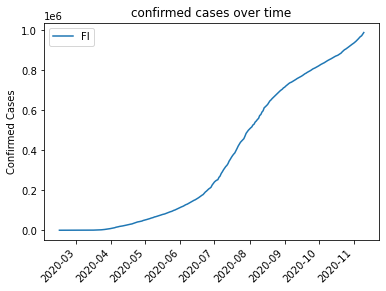

In [121]:
    plt.plot(
            complete_timeseries['dates'],
            complete_timeseries['ConfirmedCases'],
            label = 'Fl'
        )

    plt.legend()
    plt.xticks(rotation = 45, ha = "right")
    plt.ylabel("Confirmed Cases")
    plt.title("confirmed cases over time")
    plt.show()
    
    

Graph ploted above shows current immune population in California. 
This time series would be extended till end of pendamic in 1582 days (~4.5 years)